# Unsupervised Learning (Matrix Factorization)

## Setup

In [570]:
import pandas as pd
from sklearn.decomposition import NMF 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### Preliminary Data Analysis

In [571]:
# Read dataset and create training an testing datasets
# ArticleId     Text	Category
bbc_training_set = pd.read_csv('./Data/BBC News Train.csv')
print(bbc_training_set.head())
bbc_training_set.describe()

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


From the basic pandas describe() function we cannot obtain much useful information. The only valueble data is that the training dataset consists of 1490 articles. However, to obtain a better understanding of how the articles are distributed, we can focus the analysis only on the Category column. 

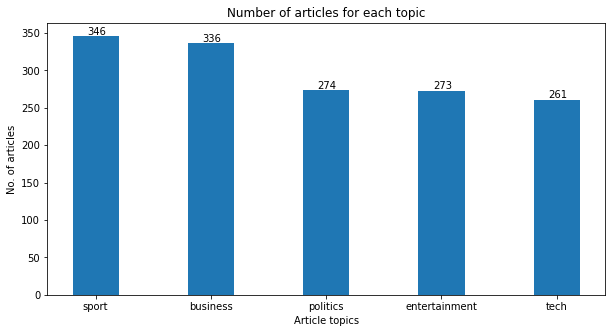

In [572]:
# creating the dataset
data = bbc_training_set["Category"].value_counts()
topics = list(data.axes[0])
values = list(data.values)
  
fig = plt.figure(figsize = (10, 5))
plt.bar(topics, values, width = 0.4)

for i in range(len(values)):
        plt.text( i-0.075, values[i]+2, values[i])

plt.xlabel("Article topics")
plt.ylabel("No. of articles")
plt.title("Number of articles for each topic")
plt.show()

We can se that the articles are roughly equally distributed, although "Sports" and "Business" articles appear to be more popular. The large number of articles allow us to split this dataset into separate "train" and "test" datasets for the creation of preliminary NMF models.

### Data setup

For this project, I have decided not to include texts from the test dataset as an input for the model training. While it is possible that the model develops some degree of overfitting, the size and diversity of texts contained within the training database itself makes it quite likely for most words of the testing dataset to have already been considered. 

Furhtermore, the final model must be robust enough to classify articles that contain new words. As such, as simple split of the training dataset shall be performed for preliminary model fitting, with the goal being a training accuracy of at least 90%.

In [573]:
train_data, test_data = train_test_split(bbc_training_set, test_size=0.2)

### TF-IDF Vectorizer

Term Frequency Inverse Document Frequency (TF-IDF) is an algorithm to transform text into a word matrix commonly used to fit machine algorithm for prediction. 

For any given word $t$ and a document $d$, Term Frequency (TF) is defined as:

$$ tf(t,d) = {\sum_{x \in d} fr(x,t) } $$
$$ fr(x,f) = \begin{cases}
                1   &\text{if x = t} \\
                0,  &otherwise
             \end{cases} $$

For any given word $t$ and a collection of documents $D$, the Inverse Document Frequency (IDF) is calculated as follows:

$$ idf(t) = {log { | D | \over {1 + | \{d : t \in d\} | }}} $$

Where $| \{d : t \in d\} |$ represents the number of documents that contain word $(t)$.

Finally, 

$$ tf─idf(t) = {tf(t,d) \times idf(t)} $$


This formula gives a high weight to words with a high term frequency(tf) in the given document(local parameter) and a low document frequency of the term in the whole collection (global parameter). This provides a measure of "originality" of the word, making it useful for topic extraction, as articles of the same topic may share words that would be "original" on other topics, making them good classifying features. 

In [574]:
# Use TD-IDF and remove tokens that don't appear in at least 10 documents and at most 300 documents
vect = TfidfVectorizer(stop_words='english')
vect = TfidfVectorizer(min_df=10, max_df=300, stop_words='english')
vect_train_data = vect.fit_transform(train_data["Text"])

In [575]:
pd_vect_train_data = pd.DataFrame(vect_train_data.toarray(), columns=vect.get_feature_names_out())
pd_vect_train_data.describe()

,000,000m,10,100,100m,10th,11,110,12,120,...,yards,yen,yes,york,young,younger,youngsters,yukos,zealand,zero
count,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,...,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000
mean,0.013219,0.001856,0.009415,0.004715,0.001943,0.000747,0.005025,0.000665,0.006102,0.001135,...,0.000927,0.001610,0.001071,0.004583,0.004793,0.001250,0.000790,0.004747,0.002675,0.000712
std,0.034243,0.023011,0.022755,0.017041,0.016682,0.008303,0.018358,0.007429,0.018256,0.010015,...,0.010284,0.014219,0.011519,0.020807,0.020945,0.010047,0.008225,0.049548,0.026035,0.007630
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.516897,0.450481,0.251182,0.134585,0.303049,0.123307,0.170533,0.110169,0.142395,0.158145,...,0.195580,0.187072,0.252497,0.270826,0.270088,0.108671,0.127775,0.707275,0.644813,0.110106


In [576]:
unique_index = pd_vect_train_data.max().argmax()
pd_vect_train_data.columns[unique_index]

'roddick'

From the vect_train_data object we can observe that the "train" set of the full training dataset has 3514 words that appear at least in 10 documents, but no more than 300. Furthermore, we can obtain the word the TD-IDF vectorized classifies as the 'most unique' across all articles: "Roddick"

## Model Creation
### Feature Extraction

We create a Non-Negative Matrix Factorization model and fit it on the previous TF-IDF word vectorizer. We set $n\_components=5$ as we have 5 possible topics to which classify each article.

In [577]:
n_components=5
model = NMF(n_components=n_components, random_state=5)
training_features = model.fit_transform(vect_train_data)
training_components = pd.DataFrame(model.components_, columns=vect.get_feature_names_out())
training_components

,000,000m,10,100,100m,10th,11,110,12,120,...,yards,yen,yes,york,young,younger,youngsters,yukos,zealand,zero
0,0.217229,0.003791,0.133235,0.050599,0.022706,0.002920,0.082252,0.016229,0.094188,0.014289,...,0.000000,0.063905,0.000351,0.074873,0.004861,0.001714,0.000000,0.22554,0.000000,0.006739
1,0.015621,0.034961,0.064674,0.008218,0.019744,0.002441,0.023797,0.002069,0.047957,0.002477,...,0.032778,0.000000,0.006874,0.011026,0.046910,0.009939,0.020725,0.00000,0.091827,0.006010
2,0.074695,0.000000,0.024533,0.028759,0.000000,0.000000,0.000832,0.000000,0.000000,0.003880,...,0.000000,0.000000,0.013824,0.000000,0.032648,0.009195,0.000000,0.00000,0.000000,0.004961
3,0.048322,0.007352,0.041367,0.005833,0.012191,0.021947,0.069277,0.004444,0.026829,0.000000,...,0.000000,0.009937,0.000000,0.043664,0.049654,0.000965,0.000000,0.00000,0.000000,0.000670
4,0.077549,0.000000,0.044888,0.053891,0.000000,0.000437,0.013647,0.002745,0.034116,0.014909,...,0.000000,0.000000,0.006995,0.019603,0.015485,0.014980,0.005812,0.00000,0.000000,0.002703


We can use the previous table to extract the main words for each topic. These would allow us to create a preliminary assignment of article topics to the model's features. 

The top 10 words for each of the model's components are graphed according to their TF-IDF score below.

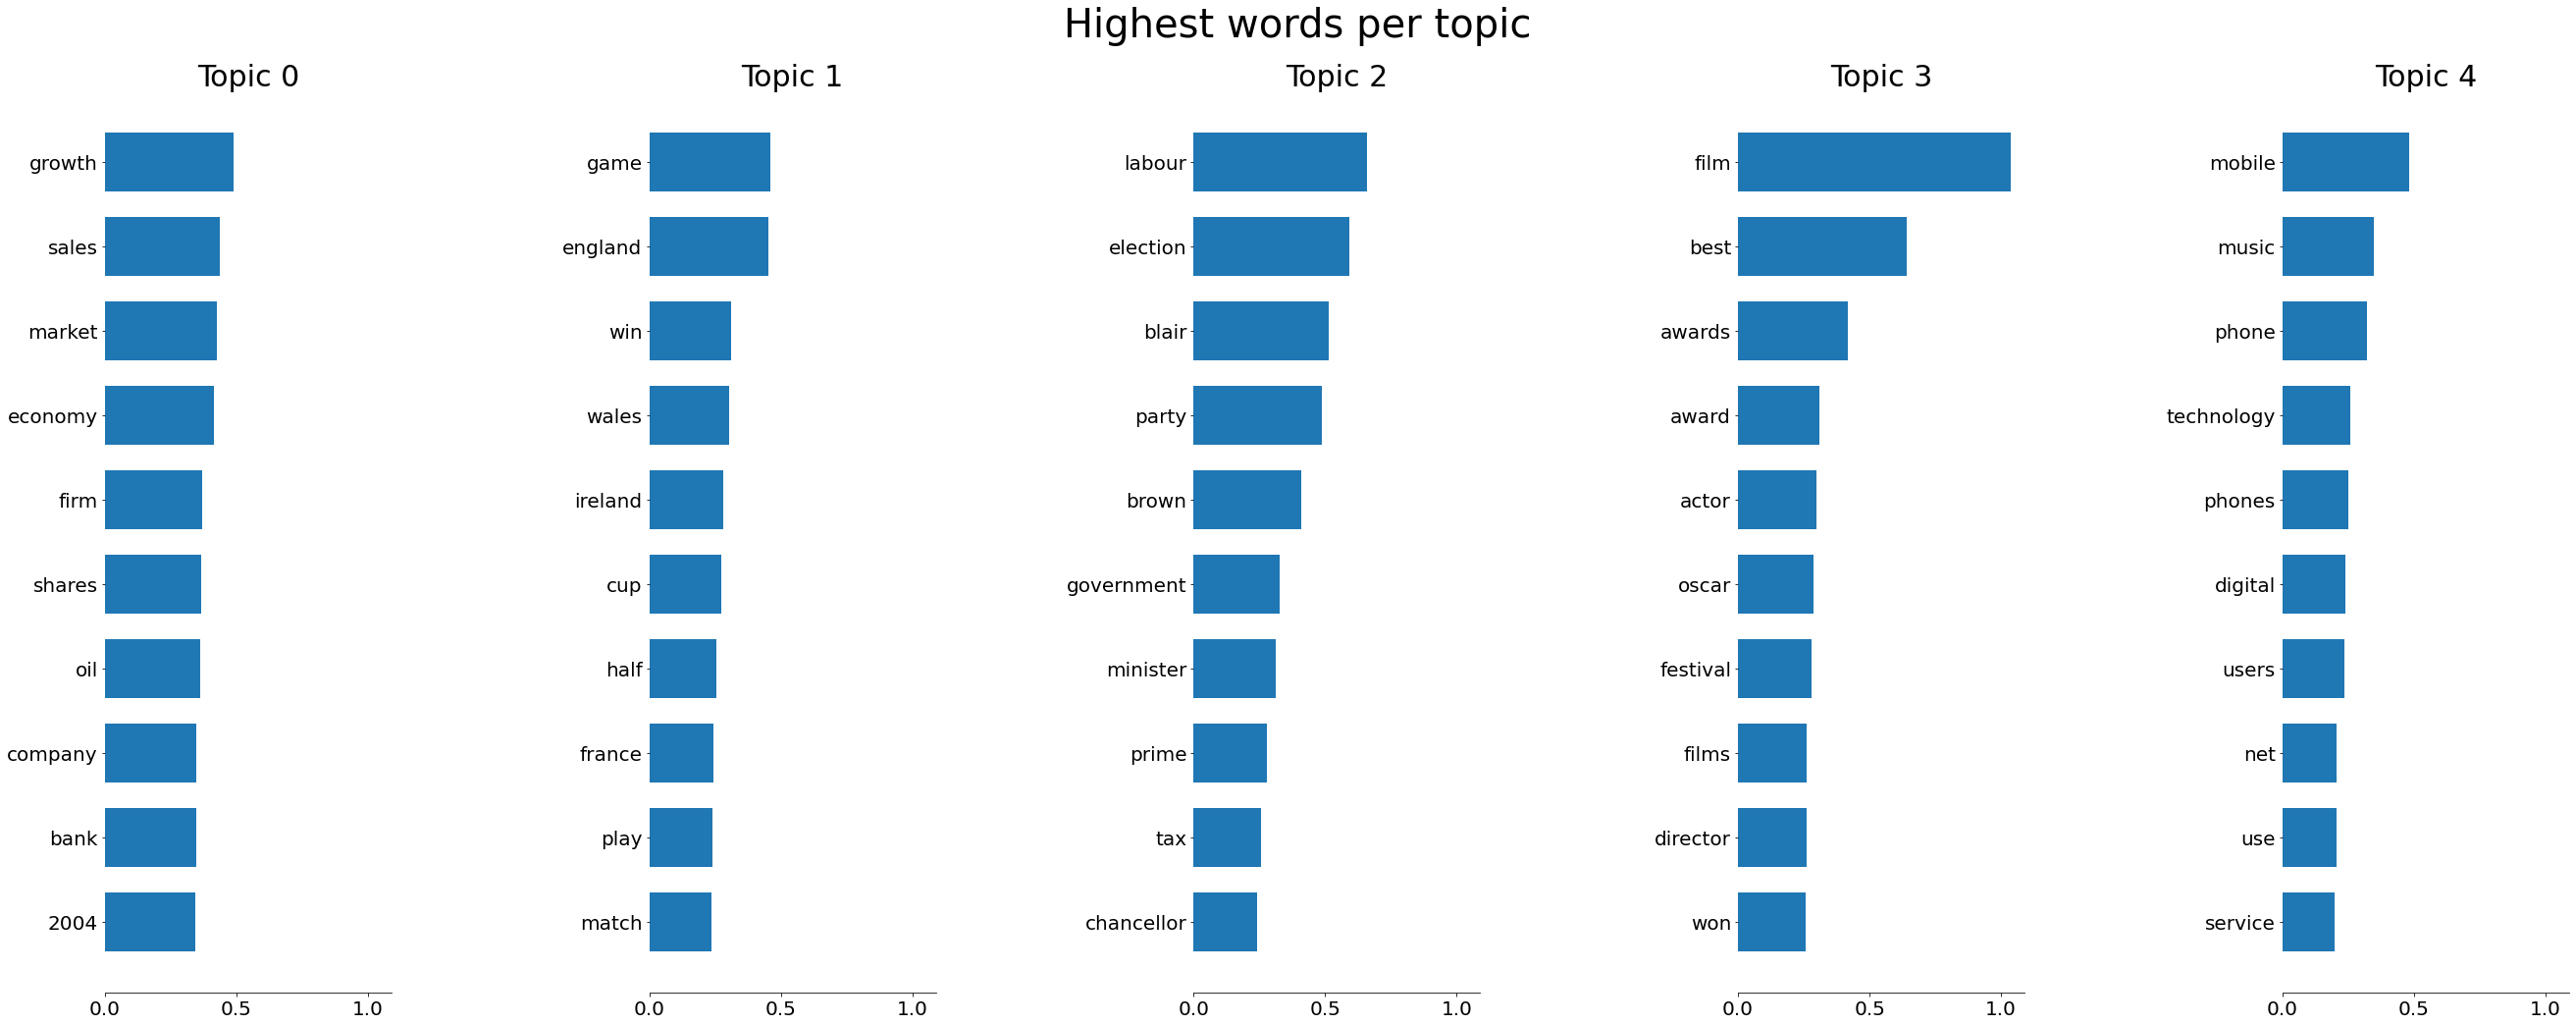

In [578]:
fig, axes = plt.subplots(1, 5, figsize=(45, 15), sharex=True)
axes = axes.flatten()

for topic in range(training_components.shape[0]):
    tmp = training_components.iloc[topic]

    top_features_table = tmp.nlargest(10)
    top_features_table = top_features_table[::-1]
    top_features = top_features_table.index.values
    weights = top_features_table.values

    ax = axes[topic]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic}", fontdict={"fontsize": 30})
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle("Highest words per topic", fontsize=40)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.show()



Analyzing the previous graphs we may conclude that the model extracted the articles' topics as follows.

* Topic 0 = Business
* Topic 1 = Politics
* Topic 2 = Sport
* Topic 3 = Entertainment
* Topic 4 = Tech

We can verify this by grouping the articles according to the model's features and extracting the predominant topic.

In [579]:
training_predictions = pd.DataFrame(training_features).idxmax(axis=1)

extracted_topics = []
for model_feature in range(len(model.components_)):
    articles = training_predictions[training_predictions == model_feature]
    rows = list(articles.index.values)
    article_topics = train_data["Category"].iloc[rows]
    extracted_topics += [article_topics.value_counts().index.values[0]]

extracted_topics

['business', 'sport', 'politics', 'entertainment', 'tech']

As we can see the model appears to have successfully extracted all five topics into distinct features. 

### Model Validation

To validate the model's efficiency we can use the "testing" dataset to create topic predictions on new text documents.
Like with the training dataset, we first pass the documents through the TD-IDF vectorizer, and it is then transformed by the fitted model.

Once we obtain the transformed matrix, we pull the feature with the highest score for each row as the article predictions.

In [580]:
# Transform the TF-IDF
vect_test_data = vect.transform(test_data["Text"])
# Transform the TF-IDF: nmf_features
testing_features = model.transform(vect_test_data)

# Convert testing features into a DataFrame
testing_predictions = pd.DataFrame(testing_features, columns=extracted_topics)
# Calculate prediction to highest feature in each row
testing_predictions.insert(5, "Prediction", testing_predictions.idxmax(axis=1), True)
# Print Predictions
testing_predictions


,business,sport,politics,entertainment,tech,Prediction
0,0.046299,0.007222,0.034375,0.009879,0.024640,business
1,0.010310,0.066772,0.008920,0.000000,0.007285,sport
2,0.032747,0.002184,0.007245,0.008398,0.053330,tech
3,0.008781,0.121796,0.014248,0.017363,0.005333,sport
4,0.006797,0.083812,0.004604,0.023797,0.000000,sport
...,...,...,...,...,...,...
293,0.098720,0.011465,0.021503,0.000000,0.000000,business
294,0.018805,0.013055,0.009760,0.053282,0.049315,entertainment
295,0.020959,0.005033,0.010727,0.174517,0.019821,entertainment
296,0.042884,0.003771,0.000000,0.000000,0.095340,tech


Finally, we can compare the model's predictions against the articles' true topics and calculate the overall accuracy.

In [581]:
results = testing_predictions[["Prediction"]].copy()
results["True Label"] = list(test_data["Category"])
results["Correct"] = results["True Label"] == results["Prediction"]

true_vals, false_vals = results["Correct"].value_counts()
accuracy = true_vals / (true_vals + false_vals)

print("Correctly predicted topics: ", true_vals)
print("Incorrectly predicted topics: ", false_vals)
print("Model's accuracy: ", accuracy)

print("\n\nModel's Confusion Matrix")
confusion_matrix(results["True Label"], results["Prediction"], labels=extracted_topics)


Correctly predicted topics:  275
Incorrectly predicted topics:  23
Model's accuracy:  0.9228187919463087


Model's Confusion Matrix


array([[52,  1,  1,  0,  2],
       [ 0, 59,  0,  0,  0],
       [ 4,  2, 55,  0,  1],
       [ 1,  2,  0, 45,  6],
       [ 0,  2,  0,  1, 64]], dtype=int64)

### Model Optimization

To obtain the parameters that give the best results, the model is created and tested multiple times, each time with a different combination of possible hyperparameters.

In [582]:
n_components = 5
init_values = [None, 'random', 'nndsvd', 'nndsvda', 'nndsvdar']
solver_values = ['cd', 'mu']
beta_loss_values = ['kullback-leibler', 'frobenius']

model_results = pd.DataFrame([], columns=["init", "beta_loss", "solver", "accuracy"])

for init in init_values:
    for beta_loss in beta_loss_values:
        for solver in solver_values:
            if solver == 'cd' and not beta_loss == 'frobenius':
                continue
            
            model = NMF(n_components=n_components, init=init, solver=solver, beta_loss=beta_loss, random_state=5)
            training_features = model.fit_transform(vect_train_data)
            training_predictions = pd.DataFrame(training_features).idxmax(axis=1)

            extracted_topics = []
            for model_feature in range(len(model.components_)):
                articles = training_predictions[training_predictions == model_feature]
                rows = list(articles.index.values)
                article_topics = train_data["Category"].iloc[rows]
                extracted_topics += [article_topics.value_counts().index.values[0]]

            # Transform the TF-IDF
            vect_test_data = vect.transform(test_data["Text"])
            # Transform the TF-IDF: nmf_features
            testing_features = model.transform(vect_test_data)

            # Convert testing features into a DataFrame
            testing_predictions = pd.DataFrame(testing_features, columns=extracted_topics)
            # Calculate prediction to highest feature in each row
            testing_predictions.insert(5, "Prediction", testing_predictions.idxmax(axis=1), True)
            # Print Predictions
            testing_predictions


            results = testing_predictions[["Prediction"]].copy()
            results["True Label"] = list(test_data["Category"])
            results["Correct"] = results["True Label"] == results["Prediction"]

            true_vals, false_vals = results["Correct"].value_counts()
            accuracy = true_vals / (true_vals + false_vals)

            model_results.loc[len(model_results.index)] = [init, beta_loss, solver, accuracy]

model_results


C:\Users\ivanm\AppData\Roaming\Python\Python310\site-packages\sklearn\decomposition\_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
C:\Users\ivanm\AppData\Roaming\Python\Python310\site-packages\sklearn\decomposition\_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
C:\Users\ivanm\AppData\Roaming\Python\Python310\site-packages\sklearn\decomposition\_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvda

,init,beta_loss,solver,accuracy
0,None,kullback-leibler,mu,0.963087
1,None,frobenius,cd,0.922819
2,None,frobenius,mu,0.912752
3,random,kullback-leibler,mu,0.929530
4,random,frobenius,cd,0.916107
5,random,frobenius,mu,0.714765
6,nndsvd,kullback-leibler,mu,0.959732
7,nndsvd,frobenius,cd,0.919463
8,nndsvd,frobenius,mu,0.869128
9,nndsvda,kullback-leibler,mu,0.963087


From the previous results we can see that both the "None" and "nndsvda" init give the best overall results. For both cases, using the "kullback-leibler" beta-loss gives the best result, which also locks the solver to being "mu".

The best accuracy result obtained, was 95.6%

### Kaggle BBC News Solution

Given the best hyperparameters extracted above, we can read the "BBC News Test.csv" file and predict each article's category. Also, to improve the model, the full training dataset will be used as an input to the final NMF model.

In [583]:
# Create a new model with the best hyperparameters fitted on the full training dataset
vect_full_train_data = vect.transform(bbc_training_set["Text"])
bbc_model = NMF(n_components=5, init="nndsvda", solver="mu", beta_loss="kullback-leibler", random_state=5)
training_features = bbc_model.fit_transform(vect_full_train_data)
training_predictions = pd.DataFrame(training_features).idxmax(axis=1)

# Correlate model's components to article topics
extracted_topics = []
for model_feature in range(len(bbc_model.components_)):
    articles = training_predictions[training_predictions == model_feature]
    rows = list(articles.index.values)
    article_topics = bbc_training_set["Category"].iloc[rows]
    extracted_topics += [article_topics.value_counts().index.values[0]]

# Read testing dataset and vectorize it
bbc_testing_set = pd.read_csv('./Data/BBC News Test.csv')
bbc_test_data = vect.transform(bbc_testing_set["Text"])

# Obtain set's feature matrix
bbc_testing_features = bbc_model.transform(bbc_test_data)
bbc_testing_predictions = pd.DataFrame(bbc_testing_features, columns=extracted_topics)
bbc_testing_predictions.insert(5, "Prediction", bbc_testing_predictions.idxmax(axis=1), True)

list(bbc_testing_predictions["Prediction"])

['sport',
 'tech',
 'sport',
 'business',
 'sport',
 'sport',
 'politics',
 'politics',
 'entertainment',
 'business',
 'business',
 'tech',
 'politics',
 'tech',
 'entertainment',
 'sport',
 'politics',
 'tech',
 'entertainment',
 'politics',
 'business',
 'politics',
 'sport',
 'business',
 'business',
 'sport',
 'business',
 'sport',
 'sport',
 'business',
 'politics',
 'tech',
 'business',
 'business',
 'sport',
 'sport',
 'sport',
 'business',
 'entertainment',
 'politics',
 'politics',
 'politics',
 'entertainment',
 'tech',
 'sport',
 'tech',
 'entertainment',
 'business',
 'politics',
 'business',
 'politics',
 'business',
 'politics',
 'business',
 'tech',
 'politics',
 'tech',
 'entertainment',
 'sport',
 'tech',
 'sport',
 'entertainment',
 'tech',
 'politics',
 'business',
 'entertainment',
 'sport',
 'tech',
 'sport',
 'sport',
 'tech',
 'sport',
 'business',
 'politics',
 'tech',
 'sport',
 'tech',
 'tech',
 'tech',
 'entertainment',
 'politics',
 'sport',
 'entertainment

The submission of the previous output to the Kaggle competition, reveals that trained model achieved an accuracy of 94.7%, which is above the desired goal for this project.

![Alt text](image.png)

### References

* [sklearn.decomposition.NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
* [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html)
* [TF-IDF Vectorizer scikit-learn](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a)
* [Topic Modelling with NMF in Python](https://predictivehacks.com/topic-modelling-with-nmf-in-python/)